In [96]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import os as so
import numpy as ny
from os import path
import pandas as ps
import pathlib as pb
from typing import List
from modules import models
import matplotlib.pyplot as pt
from modules import processing as pg
from numpy.random import default_rng


# Configure the paths to the data files
ROOT_PATH = pb.Path('..')
DATASET_PATH = pb.Path(path.join(ROOT_PATH, 'data'))
DATASET_TEST_PATH = pb.Path(path.join(DATASET_PATH, 'test'))
DATASET_TRAIN_PATH = pb.Path(path.join(DATASET_PATH, 'train'))
SUBMISSIONS_PATH = pb.Path(path.join(ROOT_PATH, 'submissions'))
DATASET_TRAIN_LABELS_FILEPATH = pb.Path(path.join(DATASET_PATH, 'train_labels.csv'))

# Use GPU if available
so.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [98]:
import tensorflow as tw

# Show warning if running on CPU
available_devices = list(map(lambda d: d.device_type, tw.config.list_physical_devices()))
print('Available devices = ', tw.config.list_physical_devices())

if 'GPU' not in available_devices:
  print('Warning: running on CPU only')

Available devices =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Number of training samples:  9000
Shape of a training sample:  (150, 3)
Number of testing samples:  5000
Shape of a testing sample:  (150, 3)


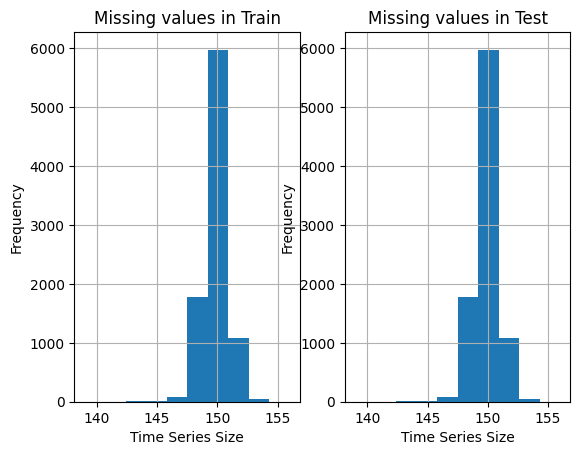

In [99]:
# Load the data from disk
dataset = pg.Dataset(DATASET_PATH)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in dataset.train_data]
test_sizes = [sample.shape[0] for sample in dataset.train_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Missing values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

In [100]:
# # Remove outliers
# dataset.remove_outliers(by='global', factor=4)

# # Compute sizes in order to search for potential missing values in each time series
# train_sizes = [sample.shape[0] for sample in dataset.train_data]
# test_sizes = [sample.shape[0] for sample in dataset.train_data]

# # Display missing value stats
# pt.figure()
# for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
#   pt.subplot(1, 2, i + 1)
#   pt.title(f'Missing values in {title.capitalize()}')
#   pt.xlabel('Time Series Size')
#   pt.ylabel('Frequency')
#   pt.hist(sizes)
#   pt.grid(True)

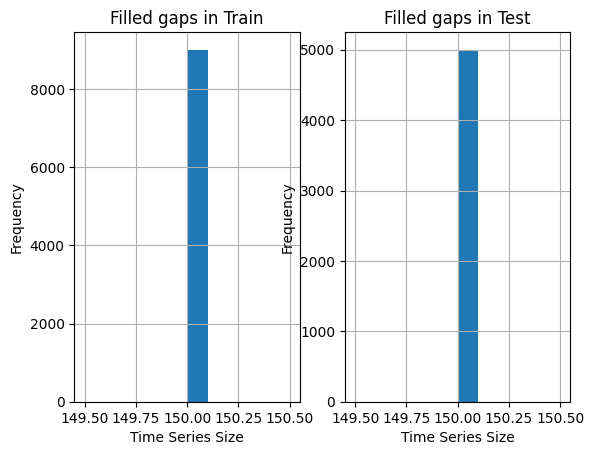

In [101]:
# Fill holes using interpolation
dataset.fill_gaps(n_size=150, min_limit=None)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in dataset.train_data]
test_sizes = [sample.shape[0] for sample in dataset.test_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Filled gaps in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

In [102]:
# Perfrom data preprocessing before normalization
dataset.preprocess(rounding=None)

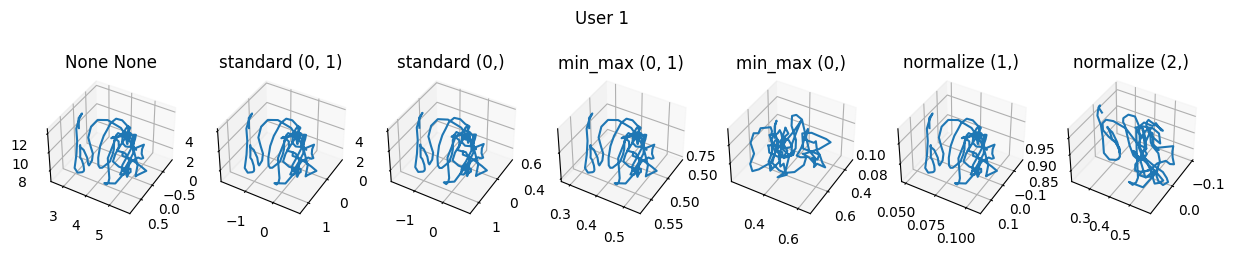

In [103]:
from numpy.random import default_rng
import copy

# Sample three recordings
gen = default_rng(24)
sample_i = gen.choice(9000, size=1, replace=False)

# Try different normalization / feature scaling methods
strategies = (
  (None, None),         # => no operation is applied    => -
  ('standard', (0, 1)), # => for each coordiante        => 3
  ('standard', (0,)),   # => temporal * each coordiante => 150 x 3
  ('min_max', (0, 1)),  # => for each coordiante        => 3
  ('min_max', (0,)),    # => temporal * each coordiante => 150 x 3
  ('normalize', (1,)),  # => norm of each coordinate    => 9000 x 3
  ('normalize', (2,)),  # => norm of each time moment   => 9000 x 150
)

# Display a sample in both sensor space and normalized space
f = pt.figure(figsize=(15, 5))
f.suptitle(f'User {i}')
for i, (strategy, axis) in enumerate(strategies):
  # Normalize copy to view different perspectives
  dataset_copy = copy.deepcopy(dataset)
  dataset_copy.normalize(strategy, axis)

  # Retrieve normalized samples
  record_x = dataset_copy.train_data[sample_i][0]

  # Display scaled vectors
  plot_n = f.add_subplot(2, len(strategies), i + 1, projection='3d')
  plot_n.plot(record_x[:, 0], record_x[:, 1], record_x[:, 2])
  plot_n.set_title(f'{strategy} {axis}')
  plot_n.view_init(elev=40, azim=30)
  del dataset_copy
pt.show()

In [104]:
# Standardize the training & testing data
dataset.normalize('standard', (0,))

# Reshape to (n_samples, n_features) commonly used format
dataset.reshape((-1, 450))

In [107]:

from tensorflow.keras.optimizers import Adam

# Model providers / factories
model_tcnn_factory = lambda: models.TCNNModel({
  'optim': lambda: Adam(learning_rate=2e-4, weight_decay=2e-5),
  'm_init': tw.keras.initializers.GlorotNormal(seed=24),
  'activ_fn': tw.keras.layers.Activation('leaky_relu'),
  'lr_update': (30, 10, 0.8),
  'n_filters': 128,
  's_filters': 3,
  'n_units': 1024,
  'dropout': 0.3,
  'n_epochs': 150,
  'n_batch': 32,
}, ROOT_PATH)

model_svm_factory = lambda: models.SVMModel({
  'C': 5,
  'gamma': 0.0005,
  'kernel': 'rbf',
}, verbose=False)

model_knn_factory = lambda: models.KNNModel({
  'n_neighbors': 5,
  'p': 2,
})

model_boosted_trees_factory = lambda: models.BoostedTreesModel({
  'learning_rate': 0.4,
  'n_estimators': 20,
  'subsample': 0.5,
  'max_depth': 2,
}, verbose = 1)

# Setup current model to be used
model_factory = model_boosted_trees_factory

In [93]:
from sklearn.model_selection import KFold

# Display periodic plots across each fold
pt.figure()

# Configure kfold loop
tparams: models.TrainParams = {
  'n_folds': 5,
}

# Train and validate using crossvalidation technique
trn_accy, val_accy = [], []
for i, (fold_train, fold_valid) in enumerate(KFold(shuffle=True, n_splits=tparams['n_folds']).split(dataset.train_data, dataset.train_labels)):
  # Indicate current iteration
  print(f"{tparams['n_folds']}-Fold: {i + 1}")

  # Create new model with random weights
  model = model_factory()

  # Gather points for each step
  train_samples_fold = dataset.train_data[fold_train.tolist()]
  valid_samples_fold = dataset.train_data[fold_valid.tolist()]
  train_labels_fold = dataset.train_labels[fold_train.tolist()]
  valid_labels_fold = dataset.train_labels[fold_valid.tolist()]

  # Learn on training data and predict on valid set
  history = model.fit(train_samples_fold, train_labels_fold, \
                      valid_samples_fold, valid_labels_fold)

  # Save max valid & train accy for the current fold
  val_accy.append(history.accuracy[1])
  trn_accy.append(history.accuracy[0])

  # Display fold results
  history.show()

# Show results across all folds
pt.show()
pt.figure()
print(f'mean_val_accy = {ny.mean(val_accy)}')
print(f'mean_trn_accy = {ny.mean(trn_accy)}')

# Show val across folds
pt.subplot(1, 2, 1)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Validation Accuracy')
pt.plot(ny.arange(tparams['n_folds']), val_accy)

# Show train across folds
pt.subplot(1, 2, 2)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Training Accuracy')
pt.plot(ny.arange(tparams['n_folds']), trn_accy)
pt.show()

5-Fold: 1
Train Accuracy: 0.9236111111111112
Valid Accuracy: 0.8666666666666667
5-Fold: 2


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

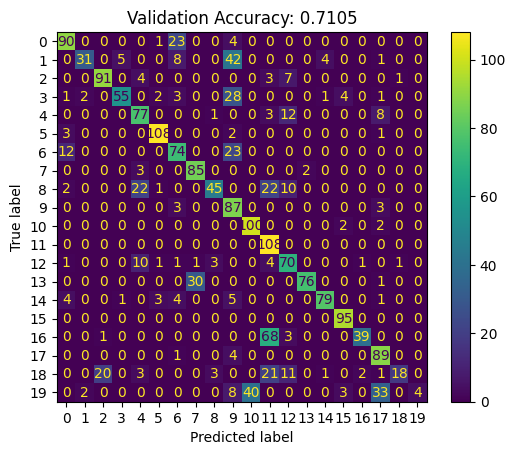

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

# Recreate model to train from scratch for subtask
model = model_factory()

# Split data indices
rnd_indices = gen.choice(len(dataset.train_data), size=len(dataset.train_data), replace=False)
n_subset_valid = 2_000
n_subset_train_i = dataset.train_data.shape[0] - n_subset_valid
n_subset_valid_i = n_subset_train_i

# Fit model on all training data except last 2_000 entries
model.fit(dataset.train_data[rnd_indices[:n_subset_train_i]], dataset.train_labels[rnd_indices[:n_subset_train_i]])

# Predict on last 2_000 entries
m_cnf = model.conf(dataset.train_data[rnd_indices[n_subset_valid_i:]], dataset.train_labels[rnd_indices[n_subset_valid_i:]])

# Transform back to labels instead of probs
f = pt.figure()
a = f.add_subplot()
a.set_title(f'Validation Accuracy: {m_cnf.trace() / m_cnf.sum()}')
ConfusionMatrixDisplay(m_cnf).plot(ax=a)
pt.show()

In [108]:
# Instantiate model for final prediction on test set
model = model_factory()

# Fit on the entire training to have more data for further predictions
rnd_indices = gen.choice(len(dataset.train_data), size=len(dataset.train_data), replace=False)
history = model.fit(dataset.train_data[rnd_indices], dataset.train_labels[rnd_indices])
print(history.accuracy[0])
history.show()

# Predict unknown labels
test_pred_labels = model.predict(dataset.test_data)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.9972           0.7671            1.34m
         2           1.6827           0.2805            1.27m
         3           1.4579           0.1732            1.20m
         4           1.3161           0.1068            1.13m
         5           1.1855           0.0326            1.06m
         6           1.0950           0.0399           59.50s
         7           1.0237           0.0377           55.25s
         8           0.9897           0.0269           51.05s
         9           0.9318          -0.5228           46.83s
        10           1.2381           0.0102           42.77s
        20          10.1132          -0.0646            0.00s
0.8176666666666667
Train Accuracy: 0.8176666666666667


In [ ]:
# Create resulting test object
test_ids = ps.Series([p.stem for p in sorted(DATASET_TEST_PATH.glob('*.csv'))], name='id')
test_classes = ps.Series(test_pred_labels, name='class')
test_results = ps.DataFrame({
  'id': test_ids,
  'class': test_classes,
})

# And store the results obtained by the model using that previously created test frame
test_results.to_csv(SUBMISSIONS_PATH / 'test_labels_23.csv', mode='w', header=True, index=False)